In [2]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/AML Project Group 20')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data Description

In [144]:
data_dir = 'ml-25m/'
genome_scores_df = pd.read_csv(data_dir + 'genome-scores.csv')
genome_tags_df = pd.read_csv(data_dir + 'genome-tags.csv')
links_df = pd.read_csv(data_dir + 'links.csv')
movies_df = pd.read_csv(data_dir + 'movies.csv')
ratings_df = pd.read_csv(data_dir + 'ratings.csv')
tags_df = pd.read_csv(data_dir + 'tags.csv')

**Ratings Data File Structure (ratings.csv)**

Each line of this file after the header row represents one rating of one movie by one user, and has the following format:  

- The lines within this file are ordered first by userId, then, within user, by movieId.
- Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [8]:
ratings_df.head(3)

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828


In [9]:
len(ratings_df)

25000095

**Tags Data File Structure (tags.csv)**  

All tags are contained in the file tags.csv. Each line of this file after the header row represents one tag applied to one movie by one user, and has the following format:  

- The lines within this file are ordered first by userId, then, within user, by movieId.
- Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.
- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [10]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598


In [11]:
len(tags_df)

1093360

**Movies Data File Structure (movies.csv)**  

Movie information is contained in the file movies.csv. Each line of this file after the header row represents one movie, and has the following format:

- Movie titles are entered manually or imported from https://www.themoviedb.org/, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

- Genres are a pipe-separated list, and are selected from the following: Action
Adventure
Animation
Children's
Comedy
Crime
Documentary
Drama
Fantasy
Film-Noir
Horror
Musical
Mystery
Romance
Sci-Fi
Thriller
War
Western
(no genres listed)

In [12]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [13]:
len(movies_df)

62423

**Links Data File Structure (links.csv)**  

Identifiers that can be used to link to other sources of movie data are contained in the file links.csv. Each line of this file after the header row represents one movie, and has the following format:

- movieId is an identifier for movies used by https://movielens.org. E.g., the movie Toy Story has the link https://movielens.org/movies/1.

- imdbId is an identifier for movies used by http://www.imdb.com. E.g., the movie Toy Story has the link http://www.imdb.com/title/tt0114709/.

- tmdbId is an identifier for movies used by https://www.themoviedb.org. E.g., the movie Toy Story has the link https://www.themoviedb.org/movie/862.

In [14]:
links_df.head(3)

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0


In [15]:
len(links_df)

62423

**Tag Genome (genome-scores.csv and genome-tags.csv)**. 

This data set includes a current copy of the Tag Genome.

The tag genome is a data structure that contains *tag relevance scores* for movies. The structure is a dense matrix: each movie in the genome has a value for every tag in the genome.

As described in this article, the tag genome encodes how strongly movies exhibit particular properties represented by tags (atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on user-contributed content including tags, ratings, and textual reviews.

Please include the following citation if referencing tag genome data:

Jesse Vig, Shilad Sen, and John Riedl. 2012. The Tag Genome: Encoding Community Knowledge to Support Novel Interaction. ACM Trans. Interact. Intell. Syst. 2, 3: 13:1–13:44. https://doi.org/10.1145/2362394.2362395

In [16]:
genome_scores_df.head(3)

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250


In [17]:
len(genome_scores_df)

15584448

In [18]:
genome_tags_df.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


In [19]:
len(genome_tags_df)

1128

# Data Merging & Data Cleaning

![relationship](relationship.png)

In [102]:
df = ratings_df.merge(tags_df,on=['userId','movieId','timestamp'],how='left')
df.head(3)

,userId,movieId,rating,timestamp,tag
0,1,296,5.0,1147880044,NaN
1,1,306,3.5,1147868817,NaN
2,1,307,5.0,1147868828,NaN


In [21]:
# convert integer timestamp into a datetime
df = df.copy()
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x / 1e3))
df.head(3)

,userId,movieId,rating,timestamp,tag
0,1,296,5.0,1970-01-14 06:51:20.044,NaN
1,1,306,3.5,1970-01-14 06:51:08.817,NaN
2,1,307,5.0,1970-01-14 06:51:08.828,NaN


In [22]:
# convert genres into multiple columns with binary values
movie_genres = movies_df.set_index('movieId').genres.str.split('|', expand=True).stack()
genres = pd.get_dummies(movie_genres, prefix='g').groupby(level=0).sum().reset_index()
genres.head(3)

,movieId,g_(no genres listed),g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,...,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western
0,1,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [23]:
df.head()

,userId,movieId,rating,timestamp,tag
0,1,296,5.0,1970-01-14 06:51:20.044,NaN
1,1,306,3.5,1970-01-14 06:51:08.817,NaN
2,1,307,5.0,1970-01-14 06:51:08.828,NaN
3,1,665,5.0,1970-01-14 06:51:18.820,NaN
4,1,899,3.5,1970-01-14 06:51:08.510,NaN


In [24]:
df = df.merge(movies_df,on=['movieId'],how='left')
df.drop(['genres'],inplace=True,axis=1)
df = df.merge(genres,on=['movieId'],how='left')
df.head(3)

,userId,movieId,rating,timestamp,tag,title,g_(no genres listed),g_Action,g_Adventure,g_Animation,...,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western
0,1,296,5.0,1970-01-14 06:51:20.044,NaN,Pulp Fiction (1994),0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,306,3.5,1970-01-14 06:51:08.817,NaN,Three Colors: Red (Trois couleurs: Rouge) (1994),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,307,5.0,1970-01-14 06:51:08.828,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
df = df.merge(links_df,on=['movieId'],how='left')
df.head(3)

,userId,movieId,rating,timestamp,tag,title,g_(no genres listed),g_Action,g_Adventure,g_Animation,...,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,imdbId,tmdbId
0,1,296,5.0,1970-01-14 06:51:20.044,NaN,Pulp Fiction (1994),0,0,0,0,...,0,0,0,0,0,1,0,0,110912,680.0
1,1,306,3.5,1970-01-14 06:51:08.817,NaN,Three Colors: Red (Trois couleurs: Rouge) (1994),0,0,0,0,...,0,0,0,0,0,0,0,0,111495,110.0
2,1,307,5.0,1970-01-14 06:51:08.828,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),0,0,0,0,...,0,0,0,0,0,0,0,0,108394,108.0


In [26]:
df = df.merge(genome_tags_df,on=['tag'],how='left')
df.head(3)

,userId,movieId,rating,timestamp,tag,title,g_(no genres listed),g_Action,g_Adventure,g_Animation,...,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,imdbId,tmdbId,tagId
0,1,296,5.0,1970-01-14 06:51:20.044,NaN,Pulp Fiction (1994),0,0,0,0,...,0,0,0,0,1,0,0,110912,680.0,NaN
1,1,306,3.5,1970-01-14 06:51:08.817,NaN,Three Colors: Red (Trois couleurs: Rouge) (1994),0,0,0,0,...,0,0,0,0,0,0,0,111495,110.0,NaN
2,1,307,5.0,1970-01-14 06:51:08.828,NaN,Three Colors: Blue (Trois couleurs: Bleu) (1993),0,0,0,0,...,0,0,0,0,0,0,0,108394,108.0,NaN


In [ ]:
df = df.merge(genome_scores_df,on=['movieId','tagId'],how='left')
df.head(3)

# Data Exploration

1.ratings

In [47]:
print('num of users:',ratings_df.userId.nunique())
print('num of movies:',ratings_df.movieId.nunique())
print('num of ratings:',ratings_df.rating.nunique())

num of users: 162541
num of movies: 59047
num of ratings: 10


Text(0.5, 1.0, 'distribution histogram of ratings')

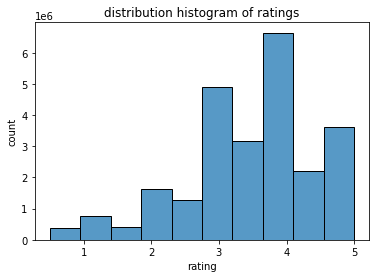

In [15]:
sns.histplot(ratings_df['rating'],stat='count',bins=10)
plt.xlabel('rating')
plt.ylabel('count')
plt.title('distribution histogram of ratings')

we can see that the most common rating value is 4, followd by 3 and 5.

In [30]:
ratings_df['userId'].value_counts().nlargest(n=10)

72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
109731     6647
92046      6564
49403      6553
30879      5693
115102     5649
Name: userId, dtype: int64

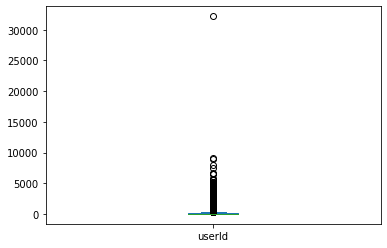

In [48]:
ratings_df['userId'].value_counts().plot.box()

In [51]:
ratings_df['userId'].value_counts().nsmallest(n=162000)

159762      20
101545      20
81982       20
71629       20
70831       20
          ... 
85254     1819
9687      1819
7865      1821
9391      1821
29999     1822
Name: userId, Length: 162000, dtype: int64

we have seen that there are 162541 users. we can see most of users rated 20-5000 times. user 72315 rated 32202 times.

In [106]:
ratings_df['timestamp']=ratings_df['timestamp'].apply(datetime.datetime.fromtimestamp)
ratings_df['year']=ratings_df['timestamp'].dt.year

In [109]:
print('year:',ratings_df.year.unique())

year: [2006 2015 2017 2016 2019 1997 1996 1999 1998 2008 2000 2005 2009 2001
 2003 2007 2002 2010 2004 2011 2013 2012 2014 2018 1995]


Text(0.5, 1.0, 'distribution histogram of year')

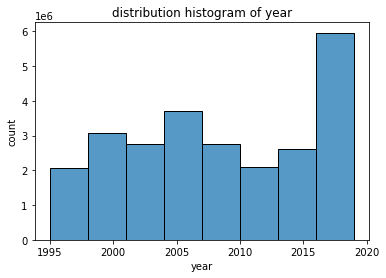

In [116]:
sns.histplot(ratings_df['year'],stat='count',binwidth=3)
plt.xlabel('year')
plt.ylabel('count')
plt.title('distribution histogram of year')

we can see that we have over 2*1e6 rating data from every 3-year time period from 1995 to 2019.

2.movies

In [145]:
movies_df['release_year']=movies_df.title.str.extract("\((\d{4})\)",expand=True).astype(str)

In [54]:
movies_df.head()

,movieId,title,genres,release_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [58]:
print('num of years:',movies_df.release_year.nunique())
print(movies_df.release_year.unique())

num of years: 136
['1995' '1994' '1996' '1976' '1992' '1988' '1967' '1993' '1964' '1977'
 '1965' '1982' '1990' '1991' '1989' '1937' '1940' '1969' '1981' '1973'
 '1970' '1960' '1955' '1959' '1968' '1980' '1975' '1986' '1948' '1943'
 '1950' '1946' '1987' '1997' '1974' '1956' '1958' '1949' '1972' '1998'
 '1933' '1952' '1951' '1957' '1961' '1954' '1934' '1944' '1963' '1942'
 '1941' '1953' '1939' '1947' '1945' '1938' '1935' '1936' '1926' '1932'
 '1985' '1979' '1971' '1978' '1966' '1962' '1983' '1984' '1931' '1922'
 '1999' '1927' '1929' '1930' '1928' '1925' '1914' '2000' '1919' '1923'
 '1920' '1918' '1921' '2001' '1924' '2002' '2003' '1915' '2004' '1916'
 '1917' '2005' '2006' '1902' '1903' '2007' '2008' '2009' '1912' '2010'
 'nan' '1913' '2011' '1898' '1899' '1894' '2012' '1910' '2013' '1896'
 '2014' '2015' '1895' '1909' '1911' '1900' '2016' '2017' '2018' '2019'
 '1905' '1904' '1891' '1892' '1908' '1897' '1887' '1888' '1890' '1878'
 '1874' '1901' '1907' '1906' '1883' '1880']


Text(0.5, 1.0, 'distribution of release year')

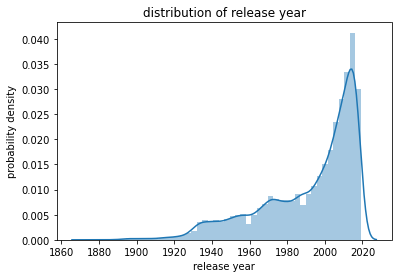

In [101]:
sns.distplot(a=movies_df['release_year'])
plt.xlabel('release year')
plt.ylabel('probability density')
plt.title('distribution of release year')

In [146]:
genres=pd.DataFrame(movies_df.genres.str.split('|').tolist()).stack().unique()
print('genres',genres)

genres ['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


In [148]:
movies_df=movies_df.join(movies_df.genres.str.get_dummies().astype(bool))
movies_df.drop('genres',inplace=True,axis=1)

In [149]:
movies_df.head()

,movieId,title,release_year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,False,False,True,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2,Jumanji (1995),1995,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,Grumpier Old Men (1995),1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
3,4,Waiting to Exhale (1995),1995,False,False,False,False,False,True,False,...,False,False,False,False,False,True,False,False,False,False
4,5,Father of the Bride Part II (1995),1995,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# TODO: the trend of different genres over the years